# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.morphology import skeletonize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import tensorflow as tf
import networkx as nx
from extra_keras_datasets import usps

# Datasets

In [2]:
datasets = {
    "mnist": {"dataloader": tf.keras.datasets.mnist.load_data, "edge_detection": False, "scale": False},
    "fashion_mnist": {"dataloader": tf.keras.datasets.fashion_mnist.load_data, "edge_detection": True, "scale": False},
    "usps": {"dataloader": usps.load_data, "edge_detection": False, "scale": True},
}

In [3]:
current_dataset = datasets["fashion_mnist"]

In [4]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
# Load  dataset
(x_train, y_train), (x_test, y_test) = current_dataset["dataloader"]()

In [6]:
images_train = x_train
images_test = x_test

In [7]:
k = 0

### Viewing an image

In [8]:
def show_image(image):
  plt.figure(figsize=(2, 2))
  plt.imshow(image, interpolation='nearest', cmap='gray')
  plt.show()

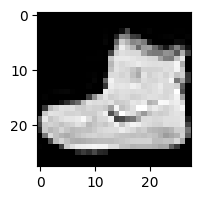

In [9]:
show_image(images_train[k])

# Preprocessing Images

In [10]:
def scale(images):
  return ((images + 1) / 2.0) * 255.0

In [11]:
if current_dataset["scale"]:
  images_train = scale(images_train)
  images_test = scale(images_test)

In [12]:
def convert_edgedetection(images):
    edge_detection = []
    for image in images:
        if image.shape[-1] == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
        
        # Apply Gaussian blur to reduce noise and smoothen edges 
        blurred = cv2.GaussianBlur(src=image, ksize=(3, 3), sigmaX=1, sigmaY=1) 
      
        # Perform Canny edge detection 
        edges = cv2.Canny(blurred, 225, 250)
        edge_detection.append(edges)
    return edge_detection

In [13]:
if current_dataset["edge_detection"]:
  edge_detection_train = convert_edgedetection(images_train)
  edge_detection_test = convert_edgedetection(images_test)
  images_train = edge_detection_train
  images_test = edge_detection_test

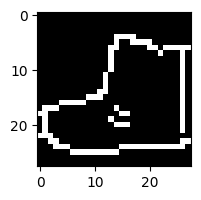

In [14]:
show_image(images_train[k])

In [15]:
def get_threshold(image):
  count = 0
  sum = 0
  med = np.median(image)
  for row in image:
    for x in row:
      if x != 0 and x >= med:
        sum += x
        count += 1
  
  return int(sum / count)

In [16]:
get_threshold(images_train[k])

255

In [17]:
def convert_binary(images):
    binary_images = []
    for image in images:
        _, thresholded = cv2.threshold(image, max(get_threshold(image) - 1, 0), 255, cv2.THRESH_BINARY)
        binary_images.append(thresholded)
    return binary_images

In [18]:
binary_images_train = convert_binary(images_train)
binary_images_test = convert_binary(images_test)

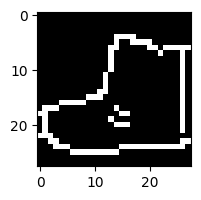

In [19]:
show_image(binary_images_train[k])

In [20]:
def convert_skeletonize(binary_images):
    skeletonized_images = []
    for binary_image in binary_images:
        skeletonized_image = skeletonize(binary_image)
        skeletonized_images.append(skeletonized_image.astype(np.uint8))
    return skeletonized_images

In [21]:
skeletonized_images_train = convert_skeletonize(binary_images_train)
skeletonized_images_test = convert_skeletonize(binary_images_test)

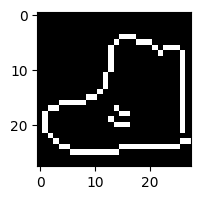

In [22]:
show_image(skeletonized_images_train[k])

# Creating Graph

In [23]:
def create_nodes(skeletonized_images):
    nodes_list = []
    node_features_list = []
    for skeletonized_image in skeletonized_images:
        nodes = []
        features = []
        for i in range(skeletonized_image.shape[0]):
            for j in range(skeletonized_image.shape[1]):
                if skeletonized_image[i, j] == 1:
                    nodes.append((i, j))
                    features.append([i, j])
        nodes_list.append(nodes)
        node_features_list.append(features)
    return nodes_list, node_features_list

In [24]:
nodes_list_train, node_features_list_train = create_nodes(skeletonized_images_train)
nodes_list_test, node_features_list_test = create_nodes(skeletonized_images_test)

In [25]:
nodes_list_train[k][:5]

[(4, 15), (4, 16), (4, 17), (5, 14), (5, 18)]

In [26]:
node_features_list_train[k][:5]

[[4, 15], [4, 16], [4, 17], [5, 14], [5, 18]]

In [27]:
def create_graph(nodes_list, skeletonized_images):
    graphs = []
    for nodes, image in zip(nodes_list, skeletonized_images):
        # Create a graph
        G = nx.Graph()

        # Add nodes for white pixels
        G.add_nodes_from(nodes)
        for i, j in nodes:
            for x in range(-1, 2):
                for y in range(-1, 2):
                    if 0 <= i + x < image.shape[0] and 0 <= j + y < image.shape[1] and (x != 0 or y != 0) and image[i + x, j + y] == 1:
                        G.add_edge((i, j), (i + x, j + y))
        graphs.append(G)
    return graphs

In [28]:
graphs_train = create_graph(nodes_list_train, skeletonized_images_train)
graphs_test = create_graph(nodes_list_test, skeletonized_images_test)

In [29]:
nodes_dict_train = [{value: index for index, value in enumerate(list)} for list in nodes_list_train]
nodes_dict_test = [{value: index for index, value in enumerate(list)} for list in nodes_list_test]

In [30]:
nodes_dict_train[k]

{(4, 15): 0,
 (4, 16): 1,
 (4, 17): 2,
 (5, 14): 3,
 (5, 18): 4,
 (5, 19): 5,
 (5, 20): 6,
 (6, 13): 7,
 (6, 21): 8,
 (6, 23): 9,
 (6, 24): 10,
 (6, 25): 11,
 (7, 13): 12,
 (7, 22): 13,
 (7, 26): 14,
 (8, 13): 15,
 (8, 26): 16,
 (9, 13): 17,
 (9, 26): 18,
 (10, 13): 19,
 (10, 26): 20,
 (11, 12): 21,
 (11, 26): 22,
 (12, 12): 23,
 (12, 26): 24,
 (13, 12): 25,
 (13, 26): 26,
 (14, 11): 27,
 (14, 26): 28,
 (15, 9): 29,
 (15, 10): 30,
 (15, 26): 31,
 (16, 4): 32,
 (16, 5): 33,
 (16, 6): 34,
 (16, 7): 35,
 (16, 8): 36,
 (16, 26): 37,
 (17, 2): 38,
 (17, 3): 39,
 (17, 14): 40,
 (17, 26): 41,
 (18, 1): 42,
 (18, 15): 43,
 (18, 16): 44,
 (18, 26): 45,
 (19, 1): 46,
 (19, 13): 47,
 (19, 26): 48,
 (20, 1): 49,
 (20, 14): 50,
 (20, 15): 51,
 (20, 16): 52,
 (20, 26): 53,
 (21, 1): 54,
 (21, 26): 55,
 (22, 2): 56,
 (23, 3): 57,
 (23, 26): 58,
 (23, 27): 59,
 (24, 4): 60,
 (24, 5): 61,
 (24, 15): 62,
 (24, 16): 63,
 (24, 17): 64,
 (24, 18): 65,
 (24, 19): 66,
 (24, 20): 67,
 (24, 21): 68,
 (24, 22):

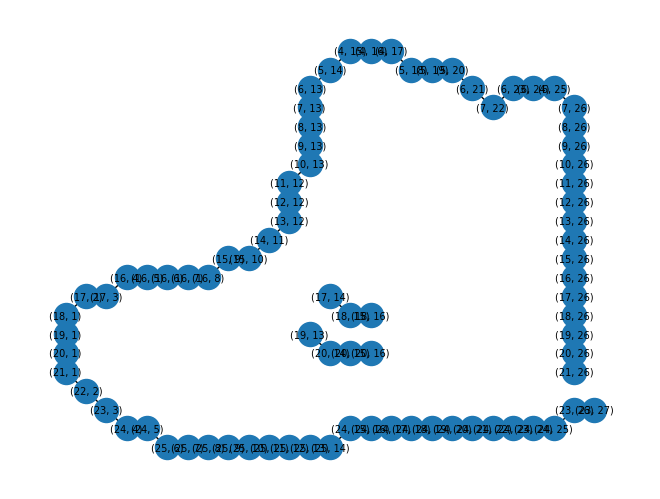

In [31]:
pos = {(i, j): (j, -i) for i, j in graphs_train[k].nodes()}
nx.draw(graphs_train[k], pos, with_labels=True, font_size=7)
plt.show()

In [32]:
def create_edge_index(graph, nodes_dict):
    edges = []
    edge_from = []
    edge_to = []
    for (i, j) in graph.edges():
        edge_from.append(nodes_dict[i])
        edge_to.append(nodes_dict[j])
    edges.append(edge_from)
    edges.append(edge_to)
    return np.array(edges)


In [33]:
graphs_train[k].edges()

EdgeView([((4, 15), (4, 16)), ((4, 15), (5, 14)), ((4, 16), (4, 17)), ((4, 17), (5, 18)), ((5, 14), (6, 13)), ((5, 18), (5, 19)), ((5, 19), (5, 20)), ((5, 20), (6, 21)), ((6, 13), (7, 13)), ((6, 21), (7, 22)), ((6, 23), (6, 24)), ((6, 23), (7, 22)), ((6, 24), (6, 25)), ((6, 25), (7, 26)), ((7, 13), (8, 13)), ((7, 26), (8, 26)), ((8, 13), (9, 13)), ((8, 26), (9, 26)), ((9, 13), (10, 13)), ((9, 26), (10, 26)), ((10, 13), (11, 12)), ((10, 26), (11, 26)), ((11, 12), (12, 12)), ((11, 26), (12, 26)), ((12, 12), (13, 12)), ((12, 26), (13, 26)), ((13, 12), (14, 11)), ((13, 26), (14, 26)), ((14, 11), (15, 10)), ((14, 26), (15, 26)), ((15, 9), (15, 10)), ((15, 9), (16, 8)), ((15, 26), (16, 26)), ((16, 4), (16, 5)), ((16, 4), (17, 3)), ((16, 5), (16, 6)), ((16, 6), (16, 7)), ((16, 7), (16, 8)), ((16, 26), (17, 26)), ((17, 2), (17, 3)), ((17, 2), (18, 1)), ((17, 14), (18, 15)), ((17, 26), (18, 26)), ((18, 1), (19, 1)), ((18, 15), (18, 16)), ((18, 26), (19, 26)), ((19, 1), (20, 1)), ((19, 13), (20,

In [34]:
edges_index_list_train = [create_edge_index(graphs_train[i], nodes_dict_train[i]) for i in range(len(images_train))]
edges_index_list_test = [create_edge_index(graphs_test[i], nodes_dict_test[i]) for i in range(len(images_test))]

In [35]:
edges_index_list_train[k]

array([[ 0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9, 10, 11, 12, 14,
        15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 29,
        31, 32, 32, 33, 34, 35, 37, 38, 38, 40, 41, 42, 43, 45, 46, 47,
        48, 49, 50, 51, 53, 54, 56, 57, 58, 58, 60, 61, 62, 62, 63, 64,
        65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80],
       [ 1,  3,  2,  4,  7,  5,  6,  8, 12, 13, 10, 13, 11, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 30, 36,
        37, 33, 39, 34, 35, 36, 41, 39, 42, 43, 45, 46, 44, 48, 49, 50,
        53, 54, 51, 52, 55, 56, 57, 60, 59, 72, 61, 73, 63, 81, 64, 65,
        66, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 81]])

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GraphConv, global_mean_pool
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader

# Making Dataset

In [37]:
class CustomGraphDataset(Dataset):
    def __init__(self, data_list):
        super(CustomGraphDataset, self).__init__()
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]

    # Additional abstract methods to implement
    def get(self, idx):
        # Implement logic to retrieve data at the given index
        return self.data_list[idx]

    def len(self):
        # Implement logic to return the length of the dataset
        return len(self.data_list)

In [38]:
def create_custom_data_instance(node_features, edges, label):
    x = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edges, dtype=torch.long)
    y = torch.tensor([label], dtype=torch.long)
    return Data(x=x, edge_index=edge_index, y=y)

In [39]:
data_list_train = [create_custom_data_instance(node_features_list_train[i], edges_index_list_train[i], y_train[i]) for i in range(len(images_train))]
custom_dataset_train = CustomGraphDataset(data_list_train)

data_list_test = [create_custom_data_instance(node_features_list_test[i], edges_index_list_test[i], y_test[i]) for i in range(len(images_test))]
custom_dataset_test = CustomGraphDataset(data_list_test)

In [40]:
num_features = custom_dataset_train.num_features
num_classes = custom_dataset_train.num_classes

In [41]:
train_dataset, val_dataset = train_test_split(custom_dataset_train, test_size=0.2, random_state=42)
test_dataset = custom_dataset_test

In [42]:
# Use PyTorch DataLoader to handle batching
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [43]:
len(train_dataset)

48000

In [44]:
test_dataset

CustomGraphDataset(10000)

In [45]:
train_dataset[k]

Data(x=[59, 2], edge_index=[2, 56], y=[1])

In [46]:
print(f'Number of Features: {num_features}, Number of Classes: {num_classes}')

Number of Features: 2, Number of Classes: 10


Graph Neural Network for Graph Classification

In [47]:
class GCNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNClassifier, self).__init__()
        self.conv1 = GraphConv(input_dim, hidden_dim[0])
        self.conv2 = GraphConv(hidden_dim[0], hidden_dim[1])
        self.conv3 = GraphConv(hidden_dim[1], hidden_dim[2])
        self.conv4 = GraphConv(hidden_dim[2], output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        # x = F.dropout(x, p=0.2)
        x = F.relu(self.conv2(x, edge_index))
        # x = F.dropout(x, p=0.2)
        x = F.relu(self.conv3(x, edge_index))
        # x = F.dropout(x, p=0.2)
        x = F.relu(self.conv4(x, edge_index))
        # x = F.dropout(x, p=0.2)
        x = global_mean_pool(x, batch)
        # x = global_add_pool(x, batch)
        return F.log_softmax(x, dim=1)

In [48]:
# Instantiate the Graph Neural Network model
input_dim = num_features
hidden_dim = [32, 16, 16]
output_dim = num_classes
gcnClassifier = GCNClassifier(input_dim, hidden_dim, output_dim)

# Define the optimizer
optimizer = torch.optim.Adam(gcnClassifier.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()

In [49]:
# Training loop
num_epochs = 100  # Increase the number of epochs
patience = 10  # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    gcnClassifier.train()
    for data in train_loader:
        optimizer.zero_grad()
        output = gcnClassifier(data)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()

    # Validation
    gcnClassifier.eval()
    val_loss = 0
    for data in val_loader:
        output = gcnClassifier(data)
        val_loss += criterion(output, data.y).item()
    val_loss /= len(val_loader)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Validation Loss: {val_loss}')

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f'Early stopping! at Epoch: {epoch + 1}')
            break

Epoch 1/100, Loss: 1.089284062385559, Validation Loss: 1.0372031327883402
Epoch 2/100, Loss: 0.8766999244689941, Validation Loss: 0.9903282540639241
Epoch 3/100, Loss: 0.8068247437477112, Validation Loss: 0.8115037542978922
Epoch 4/100, Loss: 0.7562667727470398, Validation Loss: 0.7802649388313293
Epoch 5/100, Loss: 0.6062224507331848, Validation Loss: 0.741684176603953
Epoch 6/100, Loss: 0.8059094548225403, Validation Loss: 0.7214140484333038
Epoch 7/100, Loss: 0.667644202709198, Validation Loss: 0.7341047462622324
Epoch 8/100, Loss: 0.45048293471336365, Validation Loss: 0.7007648752530415
Epoch 9/100, Loss: 1.2690857648849487, Validation Loss: 0.7048914379278819
Epoch 10/100, Loss: 0.7905208468437195, Validation Loss: 0.6916249619325002
Epoch 11/100, Loss: 0.818015992641449, Validation Loss: 0.7097348982095718
Epoch 12/100, Loss: 0.691538393497467, Validation Loss: 0.6695269192059835
Epoch 13/100, Loss: 1.2303634881973267, Validation Loss: 0.678155246257782
Epoch 14/100, Loss: 0.7053

In [50]:
# Evaluation
gcnClassifier.eval()
correct = 0
total = 0
all_predicted = []
all_labels = []

with torch.no_grad():
    for data in test_loader:
        output = gcnClassifier(data)
        _, predicted = torch.max(output, 1)
        total += data.y.size(0)
        correct += (predicted == data.y).sum().item()

        # Collect predictions and ground truth for later metric calculation
        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(data.y.cpu().numpy())

# Print classification report
print("Classification Report:\n", classification_report(all_labels, all_predicted, zero_division=1, digits=4))

Classification Report:
               precision    recall  f1-score   support

           0     0.7368    0.7390    0.7379      1000
           1     0.9671    0.9400    0.9533      1000
           2     0.5948    0.6460    0.6194      1000
           3     0.7753    0.8110    0.7928      1000
           4     0.4937    0.8240    0.6175      1000
           5     0.9017    0.8530    0.8767      1000
           6     0.6136    0.1350    0.2213      1000
           7     0.8737    0.8650    0.8693      1000
           8     0.8799    0.8790    0.8794      1000
           9     0.8840    0.9450    0.9135      1000

    accuracy                         0.7637     10000
   macro avg     0.7721    0.7637    0.7481     10000
weighted avg     0.7721    0.7637    0.7481     10000



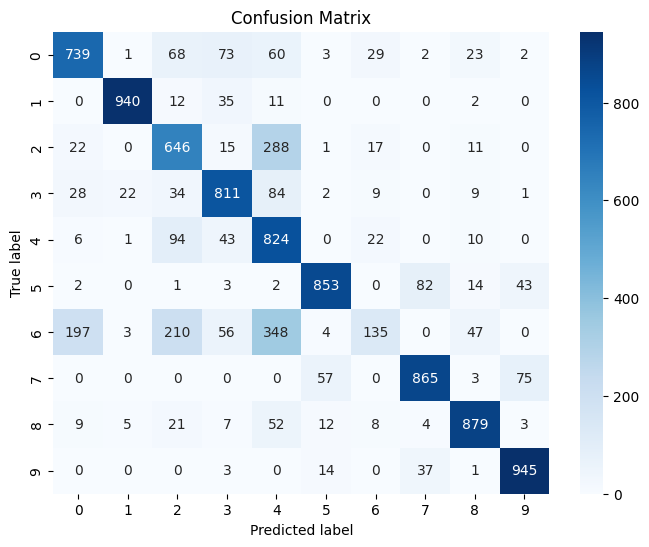

In [51]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predicted)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()